Explorando dados do Starbucks

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

Lendo os dados

In [4]:
# Lendo os dados

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Dicionário dos dados:  

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [8]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

Mapping to integer   

O código hexadecimal é grande para trabalhar

In [9]:
# _, dict_port_id = aux_fun.mapper_ids(portfolio.id)
# _, dict_prof_id = aux_fun.mapper_ids(profile.id)

map_portifolio = json.load(open('mapper_id/portifolio_ids.json'))
map_profile = json.load(open('mapper_id/profile_ids.json'))


Olhada na timeline

In [10]:
# Por usuário
cond = transcript.person == '73afdeca19e349b98f09e928644610f8'
transcript.loc[cond]

transcript.to_excel('transcript.xlsx')

Checando os usuários

,gender,age,id,became_member_on,income
1083,M,98,9696528cb958441180207375f8e608d5,20180410,52000.0
6847,F,98,96335586a1a645e8918f6810a1fc1375,20160726,91000.0
10116,M,98,66927a6c10fd4e52a73e0e1720ba4361,20170518,64000.0
13214,F,98,99767a37b09740f0935d28d9d6b1f494,20180104,65000.0
14313,M,98,75225655a1c44546a18f100f7c864f98,20150403,37000.0


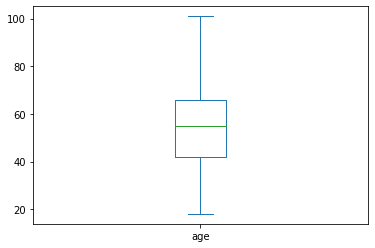

In [11]:
profile.loc[profile.age != 118].age.plot.box()
profile.loc[profile.age ==98]

Todos os usuários receberam ofertas?

In [12]:
transcript.loc[transcript.event=='offer received'].person.nunique() - profile.id.nunique() # .groupby('person', dropna=False).agg(count=('person','count')).sort_values('count')

# 6 usuários não receberam oferta

-6

Explorando a coluna value

In [11]:
# Abrindo a coluna de value

# offer_id é para ofertas completas e offer id é para ofertass enviadas

df_temp = pd.concat([transcript,pd.DataFrame(transcript.value.to_list())], axis=1)

df_temp.loc[transcript.event=='offer received']. \
    groupby(['person', 'offer id']).aggregate('count').iloc[100:110]



event  \
person                           offer id                                  
00aee28bbb3848dd8a31f0c91dc267dd ae264e3637204a6fb9bb56bc8210ddfd      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
00b18b535d6d4f779dea4dc9ac451478 2298d6c36e964ae4a3e7e9706d1fb8c2      2   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 ae264e3637204a6fb9bb56bc8210ddfd      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
00b3400e4ff64ee68ce9ada1d0c222f0 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 ae264e3637204a6fb9bb56bc8210ddfd      1   

                                                                   value  \
person                           offer id                                  
00aee28bbb3848dd8a31f0c91dc267dd ae264e3637204a6fb9bb56bc8210ddfd      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
00b18b535d6d4f779dea4dc9ac451478 2298d6c36e964ae4a3e7e9706d1fb8c2      2   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 ae264e3637204a6fb9bb56bc8210ddfd      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
00b3400e4ff64ee68ce9ada1d0c222f0 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 ae264e3637204a6fb9bb56bc8210ddfd      1   

                                                                   time  \
person                           offer id                                 
00aee28bbb3848dd8a31f0c91dc267dd ae264e3637204a6fb9bb56bc8210ddfd     1   
                                 f19421c1d4aa40978ebb69ca19b0e20d     1   
00b18b535d6d4f779dea4dc9ac451478 2298d6c36e964ae4a3e7e9706d1fb8c2     2   
                                 5a8bc65990b245e5a138643cd4eb9837     1   
                                 ae264e3637204a6fb9bb56bc8210ddfd     1   
                                 fafdcd668e3743c1bb461111dcafc2a4     1   
00b3400e4ff64ee68ce9ada1d0c222f0 0b1e1539f2cc45b7b9fa7c272da2e1d7     1   
                                 3f207df678b143eea3cee63160fa8bed     1   
                                 5a8bc65990b245e5a138643cd4eb9837     1   
                                 ae264e3637204a6fb9bb56bc8210ddfd     1   

                                                                   amount  \
person                           offer id                                   
00aee28bbb3848dd8a31f0c91dc267dd ae264e3637204a6fb9bb56bc8210ddfd       0   
                                 f19421c1d4aa40978ebb69ca19b0e20d       0   
00b18b535d6d4f779dea4dc9ac451478 2298d6c36e964ae4a3e7e9706d1fb8c2       0   
                                 5a8bc65990b245e5a138643cd4eb9837       0   
                                 ae264e3637204a6fb9bb56bc8210ddfd       0   
                                 fafdcd668e3743c1bb461111dcafc2a4       0   
00b3400e4ff64ee68ce9ada1d0c222f0 0b1e1539f2cc45b7b9fa7c272da2e1d7       0   
                                 3f207df678b143eea3cee63160fa8bed       0   
                                 5a8bc65990b245e5a138643cd4eb9837       0   
                                 ae264e3637204a6fb9bb56bc8210ddfd       0   

                                                                   offer_id  \
person                           offer id                                     
00aee28bbb3848dd8a31f0c91dc267dd ae264e3637204a6fb9bb56bc8210ddfd         0   
                                 f19421c1d4aa40978ebb69ca19b0e20d         0   
00b18b535d6d4f779dea4dc9ac451478 2298d6c36e964ae4a3e7e9706d1fb8c2         0   
                    

Nem todos os usuários receberam todas as ofertas disponíveis.  

Será que os que receberam foi efetivo a conversão?  

Pontos a organizar no dataset:
1. Quais usuários receberam quais ofertas
2. Quantos leram aquela oferta
3. Quantos completaram a oferta
4. Quanto foi o income para quem recebeu cada oferta

O problema parece caminhar para usar variáveis dummies.   
Cada linha será um usuário, que recebeu cada uma das ofertas diferentes, gerou uma resposta diferente e gastou uma quantidade diferente. Cada usuário também tem seus próprio dados demográficos, que podem servir para clusterização.

In [12]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Quando o usuário compra sem mesmo receber uma oferta, significa que ele não precisa de ofertas para comprar, o que o torna mais barato para as campanhas da empresa

O tempo vai determinar os status das ofertas. Assim, ele deve ser consolidado e resumido do dataset, usado somente para os cálculos

Campos a serem criados:
1. User
1. Ofertas recebidas
1. Ofertas visualizadas
1. Ofertas completadas
1. Transações totais

Portfolio tem 10 ids únicos  
Para cada uma dessas promoções, criar as colunas para cada usuários:   
enviada, vista, completada, transação, gasto no envio, quantidade enviada, quantidade vista, quantidade   

Quantidade de linhas  
17000 usuários, 10 * 5 colunas = 850 mil células  

É necessário analisar usuário por usuário, criando sua time line e definindo os campos  

Duas opções:
via iterrows() ou via merge  

testar qual é o mais rápido

In [14]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Passo a passo para tratamento dos dados:

1. Agrupar as ofertas recebidas

1. Verificar se essas ofertas foram visualizadas dentro do intervalo de validade  
   Contabilizar taxa de visualização

1. Verificar se essas ofertas foram completadas dentro do prazo de validade
   Calcular taxa de completas

1. Verificar quais transações foram realizadas após visualizações da oferta
   Somar total

1. Somar transações sem relações com as ofertas

Pratica 

---

In [54]:
# Selecionar um usuário
cond = transcript.person == '9f02eeb4d5d2474c96b1e3b0253a0df9' #1510
df_teste = transcript.loc[cond].reset_index().rename(columns={'index':'order'})


# Quebrar a coluna de value com seus valores
dicts_df = pd.json_normalize(df_teste['value'], meta=[['offer id', 'offer_id', 'amount', 'reward']])


# Concatenar com o dataset filtrado
df_teste = pd.concat([df_teste, dicts_df], axis=1)


# Trocar para o id da portifolio
# df_teste['offer id'] = df_teste['offer id'].map(dict_port_id)
# # Se não houver completo nenhuma oferta, passar
# try:
#     df_teste['offer_id'] = df_teste['offer_id'].map(dict_port_id)
# except:
#     pass

# Resumo do protifolio
short_portifolio = portfolio[['id', 'duration']]


# Unir o joined com infos do portifolio
df_joined = df_teste.merge(short_portifolio, left_on='offer id', right_on='id', how='left')

# Criar uma coluna com resumo do evento
import re
f = lambda eve: re.findall('(offer)(.*)', str(eve))[0][1].strip()  if 'offer' in str(eve) else str(eve)
df_joined['event2'] = df_joined.event.map(f)

# df_joined.duration = df_joined.duration * 24
df_joined

,order,person,event,value,time,offer id,amount,offer_id,reward,id,duration,event2
0,1123,9f02eeb4d5d2474c96b1e3b0253a0df9,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,received
1,15782,9f02eeb4d5d2474c96b1e3b0253a0df9,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},6,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,viewed
2,31225,9f02eeb4d5d2474c96b1e3b0253a0df9,transaction,{'amount': 27.95},54,NaN,27.95,NaN,NaN,NaN,NaN,transaction
3,31226,9f02eeb4d5d2474c96b1e3b0253a0df9,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,54,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,NaN,completed
4,38336,9f02eeb4d5d2474c96b1e3b0253a0df9,transaction,{'amount': 27.84},84,NaN,27.84,NaN,NaN,NaN,NaN,transaction
5,69576,9f02eeb4d5d2474c96b1e3b0253a0df9,transaction,{'amount': 31.75},174,NaN,31.75,NaN,NaN,NaN,NaN,transaction
6,81552,9f02eeb4d5d2474c96b1e3b0253a0df9,transaction,{'amount': 17.17},204,NaN,17.17,NaN,NaN,NaN,NaN,transaction
7,99058,9f02eeb4d5d2474c96b1e3b0253a0df9,transaction,{'amount': 30.49},270,NaN,30.49,NaN,NaN,NaN,NaN,transaction
8,111949,9f02eeb4d5d2474c96b1e3b0253a0df9,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},336,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,received
9,127394,9f02eeb4d5d2474c96b1e3b0253a0df9,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},342,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,viewed


Separação das bases

In [55]:
# Passo a passo realizado aqui

# Separar cada base das fases: recebida, visualizada, completada e transações

# Ofertas recebidas
recebidas = df_joined.loc[df_joined.event2=='received'][['person', 'offer id',  'time', 'event2', 'duration']]
recebidas['time_next'] = recebidas.shift(-1, fill_value=transcript.time.max()).time # talvez fazer um groupby ao inves, para considerar somente com o mesmo id. eu posso mandar duas ofertas diferentes para o o usuário 


visualizadas = df_joined.loc[df_joined.event2=='viewed'][['person', 'offer id',  'time', 'event2']]

transacoes = df_joined.loc[df_joined.event2=='transaction'][['person', 'time', 'event2', 'amount']]

completadas = df_joined.loc[df_joined.event2=='completed'][['person', 'offer_id', 'time', 'event2', 'reward']]

recebidas

,person,offer id,time,event2,duration,time_next
0,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,0,received,5.0,336
8,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,336,received,5.0,408
10,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,408,received,5.0,504
16,9f02eeb4d5d2474c96b1e3b0253a0df9,3f207df678b143eea3cee63160fa8bed,504,received,4.0,576
21,9f02eeb4d5d2474c96b1e3b0253a0df9,ae264e3637204a6fb9bb56bc8210ddfd,576,received,7.0,714


In [56]:
visualizadas

,person,offer id,time,event2
1,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,6,viewed
9,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,342,viewed
14,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,432,viewed
18,9f02eeb4d5d2474c96b1e3b0253a0df9,3f207df678b143eea3cee63160fa8bed,510,viewed


In [57]:
completadas

,person,offer_id,time,event2,reward
3,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,54,completed,5.0
12,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,408,completed,5.0
13,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,408,completed,5.0


In [58]:
transacoes

,person,time,event2,amount
2,9f02eeb4d5d2474c96b1e3b0253a0df9,54,transaction,27.95
4,9f02eeb4d5d2474c96b1e3b0253a0df9,84,transaction,27.84
5,9f02eeb4d5d2474c96b1e3b0253a0df9,174,transaction,31.75
6,9f02eeb4d5d2474c96b1e3b0253a0df9,204,transaction,17.17
7,9f02eeb4d5d2474c96b1e3b0253a0df9,270,transaction,30.49
11,9f02eeb4d5d2474c96b1e3b0253a0df9,408,transaction,24.18
15,9f02eeb4d5d2474c96b1e3b0253a0df9,438,transaction,30.11
17,9f02eeb4d5d2474c96b1e3b0253a0df9,504,transaction,26.58
19,9f02eeb4d5d2474c96b1e3b0253a0df9,510,transaction,22.92
20,9f02eeb4d5d2474c96b1e3b0253a0df9,558,transaction,22.37


Passo 1: quais ofertas recebidas foram visualizadas   
  
separar, aqui, as ofertas que não foram vistas.

In [66]:
# Unir por id, quais foram recebidas
df_mg1 = recebidas.merge(visualizadas, on='offer id', how='left',suffixes=('_rec', '_view') )
df_mg2 = df_mg1.loc[(df_mg1.time_view >= df_mg1.time_rec) & (df_mg1.time_view <= df_mg1.time_next)]

df_mg2


,person_rec,offer id,time_rec,event2_rec,duration,time_next,person_view,time_view,event2_view
0,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,0,received,5.0,336,9f02eeb4d5d2474c96b1e3b0253a0df9,6.0,viewed
4,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,336,received,5.0,408,9f02eeb4d5d2474c96b1e3b0253a0df9,342.0,viewed
8,9f02eeb4d5d2474c96b1e3b0253a0df9,f19421c1d4aa40978ebb69ca19b0e20d,408,received,5.0,504,9f02eeb4d5d2474c96b1e3b0253a0df9,432.0,viewed
9,9f02eeb4d5d2474c96b1e3b0253a0df9,3f207df678b143eea3cee63160fa8bed,504,received,4.0,576,9f02eeb4d5d2474c96b1e3b0253a0df9,510.0,viewed


In [ ]:

# Filtrar visualizações antes do próximo anúncio
df_mg2 = df_mg1.loc[(df_mg1.time_view >= df_mg1.time_rec) & (df_mg1.time_view <= df_mg1.time_next)]

# Criar coluna de período máximo para validar
df_mg2 = df_mg2.assign(period_max = lambda df: df.time_rec + df.duration*24 ) 

# Validar a visualização
df_mg2 = df_mg2.assign(valid_view=lambda df: df.apply(lambda df: 1 if df.time_view < df.period_max else 0, axis=1))

df_mg2
# ---


# Unir por id, quais foram recebidas
df_mg1 = recebidas.merge(visualizadas, on='offer id', how='left',suffixes=('_rec', '_view') )

# Filtrar visualizações antes do próximo anúncio

df_mg2 = df_mg1.loc[((df_mg1.time_view >= df_mg1.time_rec) & (df_mg1.time_view <= df_mg1.time_next)) | (pd.isna(df_mg1.time_view))]

df_mg2

# Criar coluna de período máximo para validar
df_mg2 = df_mg2.assign(period_max = lambda df: df.time_rec + df.duration*24 ) 

def get_viewed(df):
    if not pd.isna(df.time_view):
        if df.time_view < df.period_max:
            return 1 
        else:
            return 0
    else:
        return np.nan

# Validar a visualização
# df_mg2 = df_mg2.assign(valid_view=lambda df: df.apply(lambda df: 1 if df.time_view < df.period_max else 0, axis=1))
df_mg2 = df_mg2.assign(valid_view = lambda df: df.apply(lambda df: get_viewed(df), axis=1))

df_mg2

Passo 3: somar as transações feitas antes de completar a ofertar

In [ ]:
# Aqui vai ser necessário correr o data frame de transações e de ofertas 
# visualizadas

# Iniciar as colunaa
# df_mg5 = df_mg5.assign(tra_offer=0)
df_mg5 = df_mg2.assign(tra_offer_infl=0)


for idx, _ in df_mg5.iterrows():
    time_view = df_mg5.time_view.at[idx]
    # time_com = df_mg5.time_com.at[idx]
    time_max = df_mg5.period_max.at[idx]

    # Iterar sobre as transacoes
    sum_trans_view = 0
    sum_trans_infl = 0

    for jdx, _ in transacoes.iterrows():
        # Time da transação
        time_tra = transacoes.time.at[jdx]
        qtd_tra = transacoes.amount.at[jdx]
        
        # if (time_tra > time_view and 
        #     time_tra <= time_com):
        #     sum_trans_view += qtd_tra

        if (time_tra > time_view and
            time_tra <=  time_max):
            sum_trans_infl += qtd_tra

    # df_mg5['tra_offer'].at[idx] = sum_trans_view
    df_mg5['tra_offer_infl'].at[idx] = sum_trans_infl


df_mg5[['person_rec', 
        'offer id',
        #'event2_rec', 
        'time_rec', 
        'time_view',
        'period_max', 
        # 'time_com',
        'time_next', 
        'duration',
        'time_view',
        #'event2_view', 
        'valid_view',        
        #'offer_id', 
        # 'time_com', 
        # 'completed', 
        # 'reward',
        # 'completed_after_view',  
        'tra_offer_infl']]


,person_rec,offer id,time_rec,time_view,period_max,time_next,duration,time_view,valid_view,tra_offer_infl
0,1510,8.0,0,6.0,120.0,336,5.0,6.0,1.0,55.79
4,1510,8.0,336,342.0,456.0,408,5.0,342.0,1.0,54.29
8,1510,8.0,408,432.0,528.0,504,5.0,432.0,1.0,79.61
9,1510,2.0,504,510.0,600.0,576,4.0,510.0,1.0,22.37
10,1510,0.0,576,NaN,744.0,714,7.0,NaN,NaN,0.00


Passo 2: quais transações foram completas

In [ ]:
# Unir por id, quais foram completas
df_mg3 = df_mg5.merge(completadas, left_on='offer id', right_on='offer_id', how='left', suffixes=('', '_com'))
df_mg3 = df_mg3.rename(columns={'time':'time_com', 'event2': 'completed'})

df_mg3

# # Filtrar visualizações antes do próximo anúncio
# df_mg4 = df_mg3.loc[(df_mg3.time_com >= df_mg3.time_view) & (df_mg3.time_com <= df_mg3.time_next)]



df_mg4 = df_mg3.loc[(df_mg3.time_com >= df_mg3.time_rec) & (df_mg3.time_com <= df_mg3.period_max) | pd.isna(df_mg3.completed)]

# Aqui, mais de uma oferta pode ser feita ao mesmo tempo, que vai gerar linhas duplicadas
# O registro de mais de uma completação, pode ser para duas ofertas
df_mg4 = df_mg4.drop_duplicates()

def get_complete(df):
    if not pd.isna(df.time_com):
        if df.time_com > df.time_view:
            return 1 
        else:
            return 0
    else:
        return np.nan

# A oferta foi completada antes de ser visualizada?
df_mg4 = df_mg4.assign(completed_after_view= lambda df: df.apply(lambda df: get_complete(df), axis=1) )

df_mg4

,person_rec,offer id,time_rec,event2_rec,duration,time_next,person_view,time_view,event2_view,period_max,valid_view,tra_offer_infl,person,offer_id,time_com,completed,reward,completed_after_view
0,1510,8.0,0,received,5.0,336,1510.0,6.0,viewed,120.0,1.0,55.79,1510.0,8.0,54.0,completed,5.0,1.0
4,1510,8.0,336,received,5.0,408,1510.0,342.0,viewed,456.0,1.0,54.29,1510.0,8.0,408.0,completed,5.0,1.0
7,1510,8.0,408,received,5.0,504,1510.0,432.0,viewed,528.0,1.0,79.61,1510.0,8.0,408.0,completed,5.0,0.0
9,1510,2.0,504,received,4.0,576,1510.0,510.0,viewed,600.0,1.0,22.37,NaN,NaN,NaN,NaN,NaN,NaN
10,1510,0.0,576,received,7.0,714,NaN,NaN,NaN,744.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_mg4
transacoes

df_mg2['key'] = 0
transacoes['key'] = 0

temp = df_mg2.merge(transacoes, on='key', how='outer')

temp[['person_rec', 'offer id', 'event2_rec', 'time_next', 'time_rec',  'duration', 'period_max', 'event2_view', 'time_view', 'valid_view',
      'time', 'event2', 'amount']]#.loc[temp.time > temp.time_rec]

,person_rec,offer id,event2_rec,time_next,time_rec,duration,period_max,event2_view,time_view,valid_view,time,event2,amount
0,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,54,transaction,27.95
1,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,84,transaction,27.84
2,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,174,transaction,31.75
3,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,204,transaction,17.17
4,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,270,transaction,30.49
5,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,408,transaction,24.18
6,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,438,transaction,30.11
7,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,504,transaction,26.58
8,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,510,transaction,22.92
9,1510,8.0,received,336,0,5.0,120.0,viewed,6.0,1,558,transaction,22.37


In [ ]:
# Unir por id, quais foram recebidas
df_mg1 = recebidas.merge(visualizadas, on='offer id', how='left',suffixes=('_rec', '_view') )

# Filtrar visualizações antes do próximo anúncio

# def filter_vieweds():
#     if pd.isna(df_mg1.time_view.iloc[10])

df_mg2 = df_mg1.loc[((df_mg1.time_view >= df_mg1.time_rec) & (df_mg1.time_view <= df_mg1.time_next)) | (pd.isna(df_mg1.time_view))]

df_mg2

# Criar coluna de período máximo para validar
df_mg2 = df_mg2.assign(period_max = lambda df: df.time_rec + df.duration*24 ) 

def get_viewed(df):
    if not pd.isna(df.time_view):
        if df.time_view < df.period_max:
            return 1 
        else:
            return 0
    else:
        return np.nan

# Validar a visualização
# df_mg2 = df_mg2.assign(valid_view=lambda df: df.apply(lambda df: 1 if df.time_view < df.period_max else 0, axis=1))
df_mg2 = df_mg2.assign(valid_view = lambda df: df.apply(lambda df: get_viewed(df), axis=1))

df_mg2

,person_rec,offer id,time_rec,event2_rec,duration,time_next,person_view,time_view,event2_view,period_max,valid_view
0,1510,8.0,0,received,5.0,336,1510.0,6.0,viewed,120.0,1.0
4,1510,8.0,336,received,5.0,408,1510.0,342.0,viewed,456.0,1.0
8,1510,8.0,408,received,5.0,504,1510.0,432.0,viewed,528.0,1.0
9,1510,2.0,504,received,4.0,576,1510.0,510.0,viewed,600.0,1.0
10,1510,0.0,576,received,7.0,714,NaN,NaN,NaN,744.0,NaN


---  
Fim pratica

Organizar

In [46]:
# Selecionar um usuário
cond = transcript.person == '9f02eeb4d5d2474c96b1e3b0253a0df9' #1510
user_df = transcript.loc[cond].reset_index().rename(columns={'index':'order'})

# Resumo do protifolio
short_portifolio = portfolio[['id', 'duration']]

def get_subset(user_df, type, suffix, dict_keys):
    '''
    Get a dataset with different events and separates a subsets
    with specific type
    Input:
        user_df - (dataframe) - datafram with event of an user
        type - (string) - 'offer received', 'offer viewed', 'offer completed', 
        'transaction'
        suffix - (string) - a suffix to indtify the variables
        dict_keys - (list) - list of dict keys to extract from value column
    Output:
        df - (dataframe) - dataframe with subset
    '''
    df = user_df.loc[user_df.event==type]
    df = df[['time', 'value']]
    df = df.rename(columns={'time': 'time' + suffix})
    
    if type == 'offer received':
        df['time_next'] = df.shift(-1, 
            fill_value=transcript.time.max())['time' + suffix]
    
    # Extract value from dict
    for key in dict_keys:
        key_ = key.replace(' ', '_') # to replace empty space
        df[key_ + suffix] = df['value'].map(lambda d: d.get(key))
    df = df.drop(columns='value')

    return df 


# Received offers
received_df = get_subset(user_df,'offer received', '_rec', ['offer id'] )

# Get info from portifolio
received_df = received_df. \
    merge(short_portifolio, left_on='offer_id_rec', right_on='id'). \
    drop(columns='id')

# Viewed offers
viewed_df = get_subset(user_df, 'offer viewed', '_vie', ['offer id'] )

# Completed offers
completed_df = get_subset(user_df, 'offer completed', '_com', ['offer_id', 'reward'])

# Transactions
transaction_df = get_subset(user_df, 'transaction', '_tra', ['amount'])

In [48]:
received_df

,time_rec,time_next,offer_id_rec,duration
0,0,336,f19421c1d4aa40978ebb69ca19b0e20d,5
1,336,408,f19421c1d4aa40978ebb69ca19b0e20d,5
2,408,504,f19421c1d4aa40978ebb69ca19b0e20d,5
3,504,576,3f207df678b143eea3cee63160fa8bed,4
4,576,714,ae264e3637204a6fb9bb56bc8210ddfd,7


In [49]:
viewed_df

,time_vie,offer_id_vie
1,6,f19421c1d4aa40978ebb69ca19b0e20d
9,342,f19421c1d4aa40978ebb69ca19b0e20d
14,432,f19421c1d4aa40978ebb69ca19b0e20d
18,510,3f207df678b143eea3cee63160fa8bed


In [50]:
completed_df

,time_com,offer_id_com,reward_com
3,54,f19421c1d4aa40978ebb69ca19b0e20d,5
12,408,f19421c1d4aa40978ebb69ca19b0e20d,5
13,408,f19421c1d4aa40978ebb69ca19b0e20d,5


In [52]:
transaction_df

In [17]:
def merge_and_filter(df_left, 
    df_right, on_left, on_right,
    col_filter, col_compare):
    '''
    Merge two dataframes and apply a filter in result
    Input:
        df_left - (dataframe) - left dataframe to merge
        df_right - (dataframe) - right dataframe to merge
        on_left - (string) - key to use in merge for left
        on_right - (string) - key to use in merge for right
        col_filter - (string) - column to apply some filters
        col_compare - (list of string) - list with columns to apply filters
    Output:
        df - (dataframe) - dataframe merged and filtered 
    '''

    df = df_left.merge(df_right, 
    left_on=on_left,
    right_on=on_right,
    how='left'
    )
    
    condition1 = (df[col_filter] >= df[col_compare[0]]) 
    condition2 = (df[col_filter] <= df[col_compare[1]])
    condition3 = (pd.isna(df[col_filter])) # keep not seen offers in datase
    
    df = df.loc[condition1 & condition2 | condition3]

    return df

# Validating the visualization
def get_viewed(row):
    '''
    Auxiliar function to account for valid views
    Input: row, a dataframe coming from apply lambda
    Outpu: the validation of viewed offer
    '''
    if not pd.isna(row['time_vie']):
        if row['time_vie'] < row['period_max']:
            return 1 
        else:
            return 0
    else:
        return np.nan

# Account for completed offers without the user seen it
def get_complete(row):
    '''
    Auxliar function to account the offer complete after viewd
    Input: row, a datafram row coming from apply lambda
    Outpu: complete offer after viewed
    '''
    if not pd.isna(row['time_com']):
        if row['time_com'] > row['time_vie']: 
            return 1 
        else:
            return 0
    else:
        return np.nan


# ----------------------------------------------------------------------------
# Get the visualized offers

offer_df = merge_and_filter(received_df, viewed_df, 
    'offer_id_rec', 'offer_id_vie',
    'time_vie', ['time_rec', 'time_next']
    )

# Calculating the max time valid for offer
offer_df['period_max'] = offer_df.time_rec + offer_df.duration*24

offer_df['valid_view'] = offer_df.apply(lambda row: get_viewed(row), axis=1)

# ----------------------------------------------------------------------------


# ----------------------------------------------------------------------------
# Transactions from user, influenced by offers
offer_df['tra_offer_infl'] = 0

# Iterate over offers dataset and searching in the transactions the intervals
# considered to be influenced by an offer

for idx, _ in offer_df.iterrows():
    time_vie = offer_df['time_vie'].at[idx]
    time_max = offer_df['period_max'].at[idx]

    # Initialize variable
    sum_tra_infl = 0
    # Itarete over transactions
    for jdx, _ in transaction_df.iterrows():
        # Time of transactions
        time_tra = transaction_df['time_tra'].at[jdx]
        amo_tra  = transaction_df['amount_tra'].at[jdx]
    
        if (time_tra > time_vie and time_tra <=  time_max):
            sum_tra_infl += amo_tra
    
    # Assing to that offer
    offer_df['tra_offer_infl'].at[idx] = sum_tra_infl
# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# Complete offers

offer_df = merge_and_filter(offer_df, completed_df,
    'offer_id_rec', 'offer_id_com',
    'time_com', ['time_rec', 'period_max']
    )

# The same offer can be sent to a user and be completed together, 
# generating duplicates
offer_df = offer_df.drop_duplicates()


offer_df['completed_after_view'] = offer_df.apply(lambda row: get_complete(row), axis=1)

# -----------------------------------------------------------------------------
# Getting the status for offers
offer_df['viewed'] = offer_df.apply(lambda r: 
    1 if not pd.isna(r['offer_id_vie']) else 0,
    axis=1
    )

offer_df['completed'] = offer_df.apply(lambda r: 
    1 if not pd.isna(r['offer_id_com']) else 0,
    axis=1
    )



In [45]:
offer_df[['offer_id_rec', 'time_rec',  'time_next', 'period_max', 'time_vie', 'time_com', 
       'valid_view', 'tra_offer_infl', 'reward_com',
       'completed_after_view', 'viewed', 'completed']]

,offer_id_rec,time_rec,time_next,period_max,time_vie,time_com,valid_view,tra_offer_infl,reward_com,completed_after_view,viewed,completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,336,408,NaN,378,NaN,0.00,5,0,0,1
1,fafdcd668e3743c1bb461111dcafc2a4,336,408,576,348.0,378,1.0,583.73,2,1,1,1
2,fafdcd668e3743c1bb461111dcafc2a4,336,408,576,348.0,414,1.0,583.73,2,1,1,1
3,fafdcd668e3743c1bb461111dcafc2a4,336,408,576,408.0,378,1.0,542.21,2,0,1,1
4,fafdcd668e3743c1bb461111dcafc2a4,336,408,576,408.0,414,1.0,542.21,2,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,408,504,648,408.0,414,1.0,1200.99,2,1,1,1
7,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,576,672,NaN,504,NaN,0.00,5,0,0,1
8,2298d6c36e964ae4a3e7e9706d1fb8c2,576,714,744,606.0,588,1.0,668.88,3,0,1,1


# Transformando em uma função

In [27]:
# Functions

def get_subset(user_df, type, suffix, dict_keys):
    '''
    Get a dataset with different events and separates a subsets
    with specific type
    Input:
        user_df - (dataframe) - datafram with event of an user
        type - (string) - 'offer received', 'offer viewed', 'offer completed', 
        'transaction'
        suffix - (string) - a suffix to indtify the variables
        dict_keys - (list) - list of dict keys to extract from value column
    Output:
        df - (dataframe) - dataframe with subset
    '''
    df = user_df.loc[user_df.event==type]
    df = df[['time', 'value']]
    df = df.rename(columns={'time': 'time' + suffix})
    
    if type == 'offer received':
        df['time_next'] = df.shift(-1, 
            fill_value=transcript.time.max())['time' + suffix]
    
    # Extract value from dict
    for key in dict_keys:
        key_ = key.replace(' ', '_') # to replace empty space
        df[key_ + suffix] = df['value'].map(lambda d: d.get(key))
    df = df.drop(columns='value')

    return df 

def merge_and_filter(df_left, 
    df_right, on_left, on_right,
    col_filter, col_compare):
    '''
    Merge two dataframes and apply a filter in result
    Input:
        df_left - (dataframe) - left dataframe to merge
        df_right - (dataframe) - right dataframe to merge
        on_left - (string) - key to use in merge for left
        on_right - (string) - key to use in merge for right
        col_filter - (string) - column to apply some filters
        col_compare - (list of string) - list with columns to apply filters
    Output:
        df - (dataframe) - dataframe merged and filtered 
    '''

    df = df_left.merge(df_right, 
    left_on=on_left,
    right_on=on_right,
    how='left'
    )
    
    condition1 = (df[col_filter] >= df[col_compare[0]]) 
    condition2 = (df[col_filter] <= df[col_compare[1]])
    condition3 = (pd.isna(df[col_filter])) # keep not seen offers in datase
    
    df = df.loc[condition1 & condition2 | condition3]

    return df

def get_viewed(row):
    '''
    Auxiliar function to account for valid views
    Input: row, a dataframe coming from apply lambda
    Outpu: the validation of viewed offer
    '''
    if not pd.isna(row['time_vie']):
        if row['time_vie'] < row['period_max']:
            return 1 
        else:
            return 0
    else:
        return np.nan

def get_complete(row):
    '''
    Auxliar function to account the offer complete after viewd
    Input: row, a datafram row coming from apply lambda
    Outpu: complete offer after viewed
    '''
    if not pd.isna(row['time_com']):
        if row['time_com'] > row['time_vie']: 
            return 1 
        else:
            return 0
    else:
        return np.nan

In [28]:
def get_offer_table_user(user):
    '''
    Main function to extract informations about offers made for users.
    The ideia is analyse timeline of received, viewed and completed offer
    made by user and build a dataset with this consolitaded information.
    Input:
        user - the user id
    Output:
        offer_df - dataframe with consolitaded informations
    '''
    cond = transcript.person == user #1510
    user_df = transcript.loc[cond]

    # Resume do protifolio
    short_portifolio = portfolio[['id', 'duration']]

    # 1 - Creating the subsets
    # Received offers
    received_df = get_subset(user_df,'offer received', '_rec', ['offer id'] )
    # If user did not received any offer, skip it and return empty dataframe
    if received_df.size == 0:
        return pd.DataFrame()

    # Get info from portifolio
    received_df = received_df. \
        merge(short_portifolio, left_on='offer_id_rec', right_on='id'). \
        drop(columns='id')
    # Viewed offers
    viewed_df = get_subset(user_df, 'offer viewed', '_vie', ['offer id'] )
    # Completed offers
    completed_df = get_subset(user_df, 'offer completed', '_com', ['offer_id', 'reward'])
    # Transactions
    transaction_df = get_subset(user_df, 'transaction', '_tra', ['amount'])

    # 2 - Analizing the timeline
    # 2.1 - Visualized
    # Get the visualized offers
    offer_df = merge_and_filter(received_df, viewed_df, 
        'offer_id_rec', 'offer_id_vie',
        'time_vie', ['time_rec', 'time_next']
        )

    teste = offer_df

    # Calculating the max time valid for offer
    offer_df['period_max'] = offer_df.time_rec + offer_df.duration*24

    offer_df['valid_view'] = offer_df.apply(lambda row: get_viewed(row), axis=1)

    # Transactions from user, influenced by offers
    offer_df['tra_offer_infl'] = 0

    # 2.2 - Transactions
    # Iterate over offers dataset and searching in the transactions the intervals
    # considered to be influenced by an offer

    for idx, _ in offer_df.iterrows():
        time_vie  = offer_df['time_vie'].at[idx]
        time_max  = offer_df['period_max'].at[idx]
        # time_next = offer_df['time_next'].at[idx]

        # Initialize variable
        sum_tra_infl = 0
        # Itarete over transactions
        for jdx, _ in transaction_df.iterrows():
            # Time of transactions
            time_tra = transaction_df['time_tra'].at[jdx]
            amo_tra  = transaction_df['amount_tra'].at[jdx]
        
            if (time_tra > time_vie and 
                time_tra <= time_max #and 
                # time_tra <= time_next
                ):
                sum_tra_infl += amo_tra
        
        # Assing to that offer
        offer_df['tra_offer_infl'].at[idx] = sum_tra_infl
    
    # 2.2 - Complete offers
    # Complete offers
    offer_df = merge_and_filter(offer_df, completed_df,
        'offer_id_rec', 'offer_id_com',
        'time_com', ['time_rec', 'period_max']
        )

    # The same offer can be sent to a user and be completed together, 
    # generating duplicates
    offer_df = offer_df.drop_duplicates(
        subset=['time_rec', 'offer_id_rec', 'time_vie']
        )

    offer_df['completed_after_view'] = offer_df.apply(lambda row: get_complete(row), axis=1)

    # 2.3 - Final
    # Getting the status for offers
    offer_df['viewed'] = offer_df.apply(lambda r: 
        1 if not pd.isna(r['offer_id_vie']) else 0,
        axis=1
        )

    offer_df['completed'] = offer_df.apply(lambda r: 
        1 if not pd.isna(r['offer_id_com']) else 0,
        axis=1
        )

    # Selecting just necessary columns
    offer_df = offer_df[['offer_id_rec', 'valid_view', 'tra_offer_infl',
       'reward_com', 'completed_after_view', 'viewed', 'completed']]

    return offer_df

def expand_portifolio(offer_df, portfolio_df=portfolio.copy()):
    '''
    Take the informations from portifolio dataframe and put it
    in the offer dataframe
    Input:
        offer_df - (dataframe) dataframe with offer by user treated
        protifolio_df - (dataframe) dataframe with features of protifolio
    Output
        offer_df - (dataframe) the original dataframe with expanded
        information about offers
    '''

    # columns_portifolio = ['offer_' + column for column in portfolio_df.columns]
    # portfolio_df.columns = columns_portifolio

    offer_df = offer_df.merge(portfolio_df,
        left_on='offer_id_rec',
        right_on='id'
        )
    
    offer_df = offer_df.drop(columns=['channels', 'id', 'duration'])

    offer_df = offer_df.rename(columns={
        'reward': 'offer_reward', 
        'difficulty': 'offer_difficulty'
        }
    )

    return offer_df

def group_offer_df(offer_df, map_dict=map_portifolio):
    '''
    After an offer dataframe be created for an user, this function
    group the data and get dummies for each offer present in dataset
    Input:
        offer_df - (dataframe) datafram with data about offer for a user
        map_dict - (dict) a dictonary create initialy to converte hex to int
    Output:
        offer_df - (dataframe) dataframe with dummies variables and grouped
        data

    About metrics
        viewed_rate - the rate of views for an offer
        completed_rate - the rate of completes for an offer
        tra_offer_infl - the total of transaction because of an offer
        valid_view - for viewed offers, the rate of vizualizations in 
        validy period of an offer
        completed_after_view_rate - for complete offer, the rate of that
        was complete after was visualize
        reward - for complete offer, the total of reward won by user
    '''
    # Check if the offer_df is not empty
    if offer_df.size == 0:
        return pd.DataFrame()
    
    # Group the data and create the metrics
    offer_df = offer_df.groupby('offer_id_rec', as_index=False).agg(
        viewed_rate=('viewed', 'mean'),
        completed_rate=('completed', 'mean'),
        tra_offer_infl=('tra_offer_infl', 'sum'),
        valid_view_rate=('valid_view', 'mean'),
        completed_after_view_rate=('completed_after_view', 'mean'),
        reward_won=('reward_com', 'sum')
        )

    offer_df = expand_portifolio(offer_df)

    offer_df['offer_id_rec'] = offer_df['offer_id_rec'].map(map_dict)

    # offer_df = pd.get_dummies(offer_df, columns=['offer_id_rec', 'type'])


    return offer_df


def get_total_transaction(user):
    '''
    Some transactions might not be related with offer received, but just
    a commom one. This function get the total of transactions made by
    an user, because of an offer or not
    Input:
        user - the user id
    Output:
        total_tra - (float) total transaction
    '''

    cond = transcript.person == user #1510
    user_df = transcript.loc[cond]

    # Transactions
    transaction_df = get_subset(user_df, 'transaction', '_tra', ['amount'])

    total_tra = transaction_df['amount_tra'].sum()

    return total_tra



In [21]:
# Create the complete dataframe

def create_user_offer_df(user):
    '''
    Function to get the user and apply previous functions
    to extract informations about offers
    Input:
        user - (str, int) user id
    Output:
        user_offer_df - (dataframe) dataframe with informations about user and
        offers
    '''
    user_offer_df = get_offer_table_user(user)
    user_offer_df = group_offer_df(user_offer_df)
    user_offer_df['user_id'] = user

    user_offer_df['user_id'] = user_offer_df['user_id'].map(map_profile)

    return user_offer_df


In [69]:
get_offer_table_user('9f02eeb4d5d2474c96b1e3b0253a0df9')

AttributeError: 'Series' object has no attribute 'time_view'

In [20]:
# Group final dataset for offer received

temp = get_offer_table_user('8e0c1ffebf2a47d281210fabbd41d56a')

temp

# a = expand_portifolio(temp)

# group_offer_df(temp)

# pd.get_dummies(a, columns=['offer_id_rec', 'offer_offer_type'])
# group_offer_df(temp)

,offer_id_rec,valid_view,tra_offer_infl,reward_com,completed_after_view,viewed,completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,170,5.0,1.0,1,1
1,f19421c1d4aa40978ebb69ca19b0e20d,1,42,5.0,1.0,1,1
2,5a8bc65990b245e5a138643cd4eb9837,1,9,NaN,NaN,1,0
3,5a8bc65990b245e5a138643cd4eb9837,1,9,NaN,NaN,1,0
4,2298d6c36e964ae4a3e7e9706d1fb8c2,1,494,3.0,0.0,1,1
7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,487,3.0,0.0,1,1


In [41]:
# Iterate by user and get dataframes

users = transcript.person.unique()[:3400]
# np.random.shuffle(users)

dfs = []
cnt = 0
for user in users:
    cnt += 1
    try:
        df = create_user_offer_df(user)
        dfs.append(df)
    except:
        print(user)
    print((cnt/17000)*100, end="\r")


user_offer_df = pd.concat(dfs).reset_index(drop=True)

user_offer_df.to_csv('part1.csv')


In [40]:
user_offer_df

,offer_id_rec,viewed_rate,completed_rate,tra_offer_infl,valid_view_rate,completed_after_view_rate,reward_won,offer_reward,offer_difficulty,offer_type,user_id
0,4,1,0,0,1,NaN,0.0,5,20,discount,15
1,5,1,1,125,1,0.5,6.0,3,7,discount,15
2,6,1,1,69,1,1.0,2.0,2,10,discount,15
3,4,1,0,0,1,NaN,0.0,5,20,discount,17
4,5,1,0,0,1,NaN,0.0,3,7,discount,17
5,1,1,0,0,1,NaN,0.0,10,10,bogo,17
6,7,1,0,0,1,NaN,0.0,0,0,informational,17
7,0,1,0,0,1,NaN,0.0,10,10,bogo,17
8,4,1,0,3,1,NaN,0.0,5,20,discount,3746
9,9,1,0,2,1,NaN,0.0,2,10,discount,3746


In [73]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [279]:

def get_total_transaction(user):
    '''
    Some transactions might not be related with offer received, but just
    a commom one. This function get the total of transactions made by
    an user, because of an offer or not
    Input:
        user - the user id
    Output:
        total_tra - (float) total transaction
    '''

    cond = transcript.person == user #1510
    user_df = transcript.loc[cond]

    # Transactions
    transaction_df = get_subset(user_df, 'transaction', '_tra', ['amount'])

    total_tra = transaction_df['amount_tra'].sum()

    return total_tra

def get_subset(user_df, type, suffix, dict_keys):
    '''
    Get a dataset with different events and separates a subsets
    with specific type
    Input:
        user_df - (dataframe) - datafram with event of an user
        type - (string) - 'offer received', 'offer viewed', 'offer completed', 
        'transaction'
        suffix - (string) - a suffix to indtify the variables
        dict_keys - (list) - list of dict keys to extract from value column
    Output:
        df - (dataframe) - dataframe with subset
    '''
    df = user_df.loc[user_df.event==type]
    df = df[['time', 'value']]
    df = df.rename(columns={'time': 'time' + suffix})
    
    if type == 'offer received':
        df['time_next'] = df.shift(-1, 
            fill_value=transcript.time.max())['time' + suffix]
    
    # Extract value from dict
    for key in dict_keys:
        key_ = key.replace(' ', '_') # to replace empty space
        df[key_ + suffix] = df['value'].map(lambda d: d.get(key))
    df = df.drop(columns='value')

    return df 

def merge_and_filter(df_left, 
    df_right, on_left, on_right,
    col_filter, col_compare):
    '''
    Merge two dataframes and apply a filter in result
    Input:
        df_left - (dataframe) - left dataframe to merge
        df_right - (dataframe) - right dataframe to merge
        on_left - (string) - key to use in merge for left
        on_right - (string) - key to use in merge for right
        col_filter - (string) - column to apply some filters
        col_compare - (list of string) - list with columns to apply filters
    Output:
        df - (dataframe) - dataframe merged and filtered 
    '''

    df = df_left.merge(df_right, 
    left_on=on_left,
    right_on=on_right,
    how='left'
    )
    
    condition1 = (df[col_filter] >= df[col_compare[0]]) 
    # Se <, tira alguns valores, se <= fica mais. Testar os dois
    condition2 = (df[col_filter] < df[col_compare[1]])

    condition3 = (pd.isna(df[col_filter])) # keep not seen offers in datase
    
    df = df.loc[condition1 & condition2 | condition3]
    # df = df.loc[condition1 | condition3]

    return df

def guarantee_viewed(original, merged):
    '''
    The main point of offer user table is that it must 
    have all offer received by an user.
    Some merge operations can vanish rows of viewed offers.
    This function check original received offers and assemble
    a complete dataset
    Input:
        original - (dataframe) Dataframe with all received offers
        merged - (dataframe) Dataframe result of a merge that could
        vanish a offer received row.
    Output:
        all_df - (dataframe) A complete dataframe with all received offer
    '''
    original = original.set_index(['time_rec', 'offer_id_rec'])
    merged_index = merged.set_index(['time_rec', 'offer_id_rec'])
    
    index_original = original.index
    index_merged = merged_index.index 
    
    # Test indexs. What index is in original but not in merged
    index_exception = ~(index_original.isin(index_merged))
    # Filter the original with missing index
    original_miss = original.loc[index_exception].reset_index()
    # Join tables
    all_df = pd.concat([merged, original_miss]).reset_index(drop=True)

    return all_df

def validate_view(row):
    '''
    Auxiliar function to account for valid views
    Input: row, a dataframe coming from apply lambda
    Outpu: the validation of viewed offer
    '''
    if not pd.isna(row['time_vie']):
        if row['time_vie'] <= row['period_max']:
            return 1 
        else:
            return 0
    else:
        return np.nan

def validate_complete(row):
    '''
    Auxliar function to account the offer complete after viewd
    Input: row, a datafram row coming from apply lambda
    Outpu: complete offer after viewed
    '''
    if not pd.isna(row['time_com']):
        if row['time_com'] >= row['time_vie']: 
            return 1 
        else:
            return 0
    else:
        return np.nan

def get_offer_table_user(user):
    '''
    Main function to extract informations about offers made for users.
    The ideia is analyse timeline of received, viewed and completed offer
    made by user and build a dataset with this consolitaded information.
    Input:
        user - the user id
    Output:
        offer_df - dataframe with consolitaded informations
    '''
    cond = transcript.person == user #1510
    user_df = transcript.loc[cond]

    # Resume do protifolio
    short_portifolio = portfolio[['id', 'duration']]

    # 1 - Creating the subsets
    # Received offers
    received_df = get_subset(user_df,'offer received', '_rec', ['offer id'] )
    # If user did not received any offer, skip it and return empty dataframe
    if received_df.size == 0:
        return pd.DataFrame()

    # Get info from portifolio
    received_df = received_df. \
        merge(short_portifolio, left_on='offer_id_rec', right_on='id'). \
        drop(columns='id')
    # Viewed offers
    viewed_df = get_subset(user_df, 'offer viewed', '_vie', ['offer id'] )
    # Completed offers
    completed_df = get_subset(user_df, 'offer completed', '_com', ['offer_id', 'reward'])
    # Transactions
    transaction_df = get_subset(user_df, 'transaction', '_tra', ['amount'])

    # 2 - Analizing the timeline
    # 2.1 - Visualized
    # Get the visualized offers
    offer_df = merge_and_filter(received_df, viewed_df, 
        'offer_id_rec', 'offer_id_vie',
        'time_vie', ['time_rec', 'time_next']
        )
    offer_df = offer_df.sort_values('time_rec')
    

    # Calculating the max time valid for offer
    offer_df['period_max'] = offer_df.time_rec + offer_df.duration*24
    offer_df['valid_view'] = offer_df.apply(lambda row: validate_view(row), axis=1)

    offer_df['time_vie_next'] = offer_df['time_vie'].shift(-1, 
        fill_value=transcript.time.max()).bfill()

    temp1 = offer_df.copy()

    # Transactions from user, influenced by offers
    offer_df['tra_offer_infl'] = 0.0000

    # 2.2 - Complete offers
    # Complete offers
    offer_rec_vie = offer_df.copy()
    offer_df = merge_and_filter(offer_df, completed_df,
        'offer_id_rec', 'offer_id_com',
        'time_com', ['time_rec', 'period_max']
        )
    
    temp = guarantee_viewed(offer_rec_vie, offer_df)
    # offer_df = guarantee_viewed(offer_rec_vie, offer_df)

    offer_df = offer_df.sort_values('time_rec')
    # TODO

    # The same offer can be sent to a user and be completed together, 
    # generating duplicates
    offer_df = offer_df.drop_duplicates(
        subset=['time_rec', 'offer_id_rec', 'time_vie']
        )
    offer_df['completed_after_view'] = offer_df.apply(lambda row: validate_complete(row), axis=1)
    offer_df = guarantee_viewed(offer_rec_vie, offer_df)

    # 2.2 - Transactions
    # Iterate over offers dataset and searching in the transactions the intervals
    # considered to be influenced by an offer
    for idx, _ in offer_df.iterrows():
        time_vie  = offer_df['time_vie'].at[idx]
        time_max  = offer_df['period_max'].at[idx]
        time_next = offer_df['time_vie_next'].at[idx]
        time_com  = offer_df['time_com'].at[idx]
        
        # Check if time_vie is na. If so, there is no transaction for it
        if pd.isna(time_vie):
            offer_df['tra_offer_infl'].at[idx] = np.NaN
            continue

        # Case not complete offer, trate this as maximum value
        if pd.isna(time_com):
            time_com = transcript.time.max()

        # Initialize variable
        sum_tra_infl = 0
        # Itarete over transactions
        for jdx, _ in transaction_df.iterrows():
            # Time of transactions
            time_tra = transaction_df['time_tra'].at[jdx]
            amo_tra  = transaction_df['amount_tra'].at[jdx]
        
            if (time_tra >= time_vie) and \
                (time_tra < time_next and time_tra <= time_max and \
                time_tra <= time_com):
                sum_tra_infl += amo_tra
        
        # Assing to that offer
        offer_df['tra_offer_infl'].at[idx] = sum_tra_infl
    
    # 2.3 - Final
    # Getting the status for offers
    offer_df['viewed'] = offer_df.apply(lambda r: 
        1 if not pd.isna(r['time_vie']) else 0,
        axis=1
        )

    offer_df['completed'] = offer_df.apply(lambda r: 
        1 if not pd.isna(r['time_com']) else 0,
        axis=1
        )

    # Selecting just necessary columns
    # offer_df = offer_df[['offer_id_rec', 'valid_view', 'tra_offer_infl', 'reward_com', 'completed_after_view', 'viewed', 'completed']]

    return offer_df, temp#, temp1,temp2,temp3,temp4, completed_df, received_df, viewed_df, temp10

def group_offer_df(offer_df, map_dict=map_portifolio):
    '''
    After an offer dataframe be created for an user, this function
    group the data and get dummies for each offer present in dataset
    Input:
        offer_df - (dataframe) datafram with data about offer for a user
        map_dict - (dict) a dictonary create initialy to converte hex to int
    Output:
        offer_df - (dataframe) dataframe with dummies variables and grouped
        data

    About metrics
        viewed_rate - the rate of views for an offer
        completed_rate - the rate of completes for an offer
        tra_offer_infl - the total of transaction because of an offer
        valid_view - for viewed offers, the rate of vizualizations in 
        validy period of an offer
        completed_after_view_rate - for complete offer, the rate of that
        was complete after was visualize
        reward - for complete offer, the total of reward won by user
    '''
    # Check if the offer_df is not empty
    if offer_df.size == 0:
        return pd.DataFrame()
    
    # Group the data and create the metrics
    offer_df = offer_df.groupby('offer_id_rec', as_index=False).agg(
        viewed_rate=('viewed', 'mean'),
        completed_rate=('completed', 'mean'),
        tra_offer_infl=('tra_offer_infl', 'sum'),
        valid_view_rate=('valid_view', 'mean'),
        completed_after_view_rate=('completed_after_view', 'mean'),
        reward_won=('reward_com', 'sum')
        )

    # offer_df = expand_portifolio(offer_df)
    # TODO

    offer_df['offer_id_rec'] = offer_df['offer_id_rec'].map(map_dict)

    return offer_df

def create_user_offer_df(user):
    '''
    Function to get the user and apply previous functions
    to extract informations about offers
    Input:
        user - (str, int) user id
    Output:
        user_offer_df - (dataframe) dataframe with informations about user and
        offers
    '''
    user_offer_df = get_offer_table_user(user)
    user_offer_df = group_offer_df(user_offer_df)
    user_offer_df['user_id'] = user

    user_offer_df['user_id'] = user_offer_df['user_id'].map(map_profile)

    return user_offer_df

In [294]:
# get_offer_table_user('dce784e26f294101999d000fad9089bb')#[['offer_id_rec', 'time_rec', 'time_next', 'time_vie', 'time_vie_next','time_com', 'duration', 'period_max', 'valid_view', 'tra_offer_infl', 'reward_com', 'completed_after_view','viewed', 'completed']]

# temp__1 = get_offer_table_user('dce784e26f294101999d000fad9089bb')[1]
# temp__2 = get_offer_table_user('dce784e26f294101999d000fad9089bb')[3]
# rec = get_offer_table_user('dce784e26f294101999d000fad9089bb')[6]
# vi = get_offer_table_user('dce784e26f294101999d000fad9089bb')[7]

# temp22 = get_offer_table_user('dce784e26f294101999d000fad9089bb')[3]
# com = get_offer_table_user('dce784e26f294101999d000fad9089bb')[5]

teste = get_offer_table_user('5d02eeee2ca447b38e0e47c5e7466872')[0]

teste

,time_rec,time_next,offer_id_rec,duration,time_vie,offer_id_vie,period_max,valid_view,time_vie_next,tra_offer_infl,time_com,offer_id_com,reward_com,completed_after_view,viewed,completed
0,0,336,3f207df678b143eea3cee63160fa8bed,4,330.0,3f207df678b143eea3cee63160fa8bed,96,0.0,360.0,0.00,NaN,NaN,NaN,NaN,1,0
1,336,408,ae264e3637204a6fb9bb56bc8210ddfd,7,360.0,ae264e3637204a6fb9bb56bc8210ddfd,504,1.0,558.0,19.42,378.0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1.0,1,1
2,408,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,NaN,NaN,648,NaN,558.0,NaN,432.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0.0,0,1
3,504,576,5a8bc65990b245e5a138643cd4eb9837,3,558.0,5a8bc65990b245e5a138643cd4eb9837,576,1.0,588.0,693.39,NaN,NaN,NaN,NaN,1,0
4,576,714,5a8bc65990b245e5a138643cd4eb9837,3,588.0,5a8bc65990b245e5a138643cd4eb9837,648,1.0,714.0,24.99,NaN,NaN,NaN,NaN,1,0


In [293]:
get_offer_table_user('5d02eeee2ca447b38e0e47c5e7466872')[1]

,time_rec,time_next,offer_id_rec,duration,time_vie,offer_id_vie,period_max,valid_view,time_vie_next,tra_offer_infl,time_com,offer_id_com,reward_com
0,0,336,3f207df678b143eea3cee63160fa8bed,4,330.0,3f207df678b143eea3cee63160fa8bed,96,0.0,360.0,0.0,NaN,NaN,NaN
1,336,408,ae264e3637204a6fb9bb56bc8210ddfd,7,360.0,ae264e3637204a6fb9bb56bc8210ddfd,504,1.0,558.0,0.0,378.0,ae264e3637204a6fb9bb56bc8210ddfd,10.0
2,408,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,NaN,NaN,648,NaN,558.0,0.0,432.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
3,504,576,5a8bc65990b245e5a138643cd4eb9837,3,558.0,5a8bc65990b245e5a138643cd4eb9837,576,1.0,588.0,0.0,NaN,NaN,NaN
4,576,714,5a8bc65990b245e5a138643cd4eb9837,3,588.0,5a8bc65990b245e5a138643cd4eb9837,648,1.0,714.0,0.0,NaN,NaN,NaN


In [160]:
df_1 = temp11.merge(com, left_on='offer_id_rec', right_on='offer_id_com')
df = temp11.merge(com, left_on='offer_id_rec', right_on='offer_id_com')
condition1 = (df['time_com'] >= df['time_vie']) 
# Se <, tira alguns valores, se <= fica mais. Testar os dois
condition2 = (df['time_com'] < df['period_max'])

condition3 = (pd.isna(df['time_com'])) # keep not seen offers in datase
    
df = df.loc[condition1 & condition2 | condition3]
df_1

,time_rec,time_next,offer_id_rec,duration,time_vie,offer_id_vie,period_max,valid_view,time_vie_next,tra_offer_infl,time_com,offer_id_com,reward_com
0,0,336,fafdcd668e3743c1bb461111dcafc2a4,10,42,fafdcd668e3743c1bb461111dcafc2a4,240,1,366,0.0,42,fafdcd668e3743c1bb461111dcafc2a4,2
1,0,336,fafdcd668e3743c1bb461111dcafc2a4,10,42,fafdcd668e3743c1bb461111dcafc2a4,240,1,366,0.0,372,fafdcd668e3743c1bb461111dcafc2a4,2
2,0,336,fafdcd668e3743c1bb461111dcafc2a4,10,42,fafdcd668e3743c1bb461111dcafc2a4,240,1,366,0.0,558,fafdcd668e3743c1bb461111dcafc2a4,2
3,336,408,fafdcd668e3743c1bb461111dcafc2a4,10,366,fafdcd668e3743c1bb461111dcafc2a4,576,1,426,0.0,42,fafdcd668e3743c1bb461111dcafc2a4,2
4,336,408,fafdcd668e3743c1bb461111dcafc2a4,10,366,fafdcd668e3743c1bb461111dcafc2a4,576,1,426,0.0,372,fafdcd668e3743c1bb461111dcafc2a4,2
5,336,408,fafdcd668e3743c1bb461111dcafc2a4,10,366,fafdcd668e3743c1bb461111dcafc2a4,576,1,426,0.0,558,fafdcd668e3743c1bb461111dcafc2a4,2
6,504,576,fafdcd668e3743c1bb461111dcafc2a4,10,528,fafdcd668e3743c1bb461111dcafc2a4,744,1,654,0.0,42,fafdcd668e3743c1bb461111dcafc2a4,2
7,504,576,fafdcd668e3743c1bb461111dcafc2a4,10,528,fafdcd668e3743c1bb461111dcafc2a4,744,1,654,0.0,372,fafdcd668e3743c1bb461111dcafc2a4,2
8,504,576,fafdcd668e3743c1bb461111dcafc2a4,10,528,fafdcd668e3743c1bb461111dcafc2a4,744,1,654,0.0,558,fafdcd668e3743c1bb461111dcafc2a4,2
9,408,504,f19421c1d4aa40978ebb69ca19b0e20d,5,426,f19421c1d4aa40978ebb69ca19b0e20d,528,1,528,0.0,438,f19421c1d4aa40978ebb69ca19b0e20d,5


In [214]:
# str(df['time_rec']) + df['offer_id_rec']
# b = df_1[['time_rec', 'offer_id_rec']].drop_duplicates()
# np.setdiff1d(a, b)

rec_val = rec.set_index(['time_rec', 'offer_id_rec'])
temp__2_val = temp__2.set_index(['time_rec', 'offer_id_rec'])

# # np.setdiff1d(rec_val, temp__2_val)
# in1 = rec_val.index
# con = ~(in1.isin(in2))
# # in2 = temp__2_val.index
# rec_val.loc[con].reset_index()
# pd.concat([temp__2, rec_val.loc[con].reset_index()])

,time_rec,time_next,offer_id_rec,duration,time_vie,offer_id_vie,period_max,valid_view,time_vie_next,tra_offer_infl,time_com,offer_id_com,reward_com,completed_after_view
0,0,336,fafdcd668e3743c1bb461111dcafc2a4,10,42.0,fafdcd668e3743c1bb461111dcafc2a4,240.0,1.0,366.0,0.0,42.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
4,336,408,fafdcd668e3743c1bb461111dcafc2a4,10,366.0,fafdcd668e3743c1bb461111dcafc2a4,576.0,1.0,426.0,0.0,372.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
6,408,504,f19421c1d4aa40978ebb69ca19b0e20d,5,426.0,f19421c1d4aa40978ebb69ca19b0e20d,528.0,1.0,528.0,0.0,438.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0
9,504,576,fafdcd668e3743c1bb461111dcafc2a4,10,528.0,fafdcd668e3743c1bb461111dcafc2a4,744.0,1.0,654.0,0.0,558.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
0,576,714,f19421c1d4aa40978ebb69ca19b0e20d,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:



guarantee_viewed(temp11, temp22)


,time_rec,time_next,offer_id_rec,duration,time_vie,offer_id_vie,period_max,valid_view,time_vie_next,tra_offer_infl,time_com,offer_id_com,reward_com,completed_after_view
0,0,336,fafdcd668e3743c1bb461111dcafc2a4,10,42,fafdcd668e3743c1bb461111dcafc2a4,240,1,366,0.0,42.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
4,336,408,fafdcd668e3743c1bb461111dcafc2a4,10,366,fafdcd668e3743c1bb461111dcafc2a4,576,1,426,0.0,372.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
6,408,504,f19421c1d4aa40978ebb69ca19b0e20d,5,426,f19421c1d4aa40978ebb69ca19b0e20d,528,1,528,0.0,438.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0
9,504,576,fafdcd668e3743c1bb461111dcafc2a4,10,528,fafdcd668e3743c1bb461111dcafc2a4,744,1,654,0.0,558.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0
0,576,714,f19421c1d4aa40978ebb69ca19b0e20d,5,654,f19421c1d4aa40978ebb69ca19b0e20d,696,1,714,0.0,NaN,NaN,NaN,NaN


In [78]:
get_total_transaction('454b00bdd77c4f588eb9f6cafd81dc5d')

create_user_offer_df ('dce784e26f294101999d000fad9089bb')

AttributeError: 'tuple' object has no attribute 'size'